In [86]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [88]:
transactions1 = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Project /Transactional_data_retail_01.csv')
transactions2 = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Project /Transactional_data_retail_02.csv')
customer_data = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Project /CustomerDemographics.csv')
product_info = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Project /ProductInfo.csv')

In [89]:
transactions = pd.concat([transactions1, transactions2])

In [90]:
print(transactions.head())
print(customer_data.head())
print(product_info.head())

  Invoice StockCode  Quantity  Price  Customer ID       InvoiceDate
0  489434     85048        12   6.95      13085.0  01 December 2021
1  489434    79323P        12   6.75      13085.0  01 December 2021
2  489434    79323W        12   6.75      13085.0  01 December 2021
3  489434     22041        48   2.10      13085.0  01 December 2021
4  489434     21232        24   1.25      13085.0  01 December 2021
   Customer ID         Country
0        13085  United Kingdom
1        13078  United Kingdom
2        15362  United Kingdom
3        18102  United Kingdom
4        12682          France
  StockCode                          Description
0    85123A   WHITE HANGING HEART T-LIGHT HOLDER
1     71053                  WHITE METAL LANTERN
2    84406B       CREAM CUPID HEARTS COAT HANGER
3    84029G  KNITTED UNION FLAG HOT WATER BOTTLE
4    84029E       RED WOOLLY HOTTIE WHITE HEART.


In [91]:
# Convert InvoiceDate to datetime format, using dayfirst=True to handle ambiguous formats
transactions['InvoiceDate'] = pd.to_datetime(transactions['InvoiceDate'], dayfirst=True, errors='coerce')

# Check for any rows where InvoiceDate is still null (couldn't be parsed)
print(transactions[transactions['InvoiceDate'].isna()])

# Drop or handle rows with invalid dates (if necessary)
transactions.dropna(subset=['InvoiceDate'], inplace=True)

# Preview the fixed data
print(transactions.head())

       Invoice StockCode  Quantity  Price  Customer ID InvoiceDate
0       536365    85123A         6   2.55      17850.0         NaT
1       536365     71053         6   3.39      17850.0         NaT
2       536365    84406B         8   2.75      17850.0         NaT
3       536365    84029G         6   3.39      17850.0         NaT
4       536365    84029E         6   3.39      17850.0         NaT
...        ...       ...       ...    ...          ...         ...
541905  581587     22899         6   2.10      12680.0         NaT
541906  581587     23254         4   4.15      12680.0         NaT
541907  581587     23255         4   4.15      12680.0         NaT
541908  581587     22138         3   4.95      12680.0         NaT
541909  581587      POST         1  18.00      12680.0         NaT

[541910 rows x 6 columns]
  Invoice StockCode  Quantity  Price  Customer ID InvoiceDate
0  489434     85048        12   6.95      13085.0  2021-12-01
1  489434    79323P        12   6.75      130

In [92]:
# Check column names in both DataFrames
print("Transaction columns:", transactions.columns)
print("Product info columns:", product_info.columns)

Transaction columns: Index(['Invoice', 'StockCode', 'Quantity', 'Price', 'Customer ID',
       'InvoiceDate'],
      dtype='object')
Product info columns: Index(['StockCode', 'Description'], dtype='object')


In [93]:
merged_data = transactions.merge(product_info, on='StockCode', how='left')

In [94]:
merged_data = merged_data.merge(customer_data, on='Customer ID', how='left')


In [95]:
top_10_quantity = merged_data.groupby('StockCode')['Quantity'].sum().nlargest(10).reset_index()


In [96]:
# Top 10 products based on revenue (Quantity * UnitPrice)
merged_data['Revenue'] = merged_data['Quantity'] * merged_data['Price']
top_10_revenue = merged_data.groupby('StockCode')['Revenue'].sum().nlargest(10).reset_index()

In [97]:
print("Top 10 Products by Quantity Sold:\n", top_10_quantity)
print("Top 10 Products by Revenue:\n", top_10_revenue)

Top 10 Products by Quantity Sold:
   StockCode  Quantity
0    85123A    286180
1    85099B    193504
2     84879    133452
3     21212    118822
4     22423    102272
5     21181    100528
6     22197     91652
7     20713     86238
8     37410     75981
9     84270     71408
Top 10 Products by Revenue:
   StockCode     Revenue
0     22423  1304411.68
1    85123A   779127.60
2    85099B   355689.92
3       DOT   232803.98
4     84879   217362.36
5     21843   211669.25
6     21181   205272.32
7     20685   197988.80
8     21621   179098.55
9     20713   165074.22


In [98]:
import seaborn as sns
import matplotlib.pyplot as plt

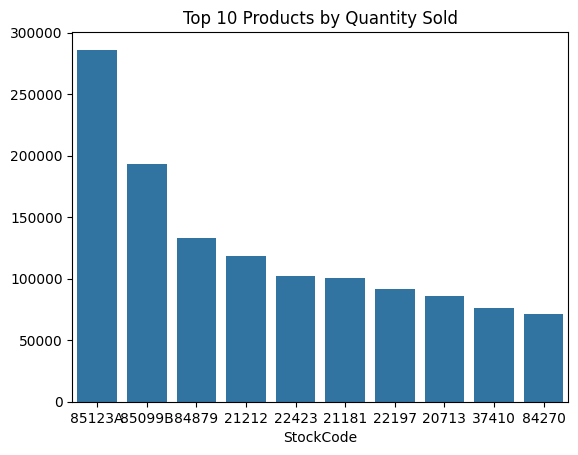

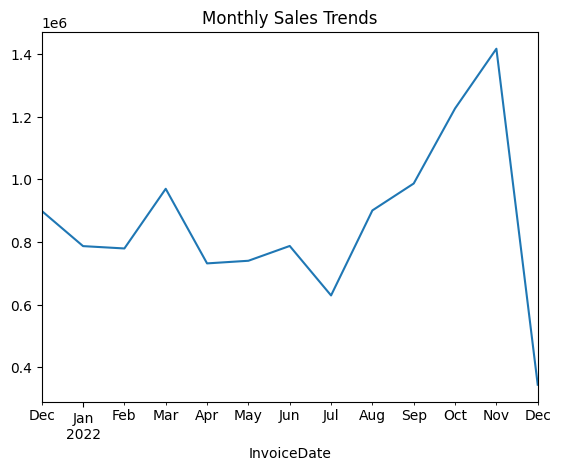

In [99]:
# Top 10 products by quantity sold
top_10_products = merged_data.groupby('StockCode')['Quantity'].sum().nlargest(10)
sns.barplot(x=top_10_products.index, y=top_10_products.values)
plt.title('Top 10 Products by Quantity Sold')
plt.show()

# Sales trends over time
merged_data.set_index('InvoiceDate').resample('M')['Quantity'].sum().plot()
plt.title('Monthly Sales Trends')
plt.show()

In [100]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

In [101]:
# For each top product (replace 'stockcode' with actual stock code from top 10)
for stock in top_10_quantity['StockCode']: # Iterate over the 'stockcode' column
    # Isolate sales data for the product
    product_sales = merged_data[merged_data['StockCode'] == stock].set_index('InvoiceDate').resample('W')['Quantity'].sum()

    # Check if product
    if not product_sales.empty:
        # Fit ARIMA model
        model = ARIMA(product_sales, order=(5, 1, 0))
        model_fit = model.fit()

In [102]:
# Forecast future sales for the next 10 weeks
forecast = model_fit.forecast(steps=10)

# Print the forecasted values
print(forecast)

2022-12-18   -300.337606
2022-12-25   -897.822216
2023-01-01   -244.595762
2023-01-08   -532.315316
2023-01-15   -508.901052
2023-01-22   -438.214809
2023-01-29   -541.245801
2023-02-05   -437.415957
2023-02-12   -497.810525
2023-02-19   -499.432624
Freq: W-SUN, Name: predicted_mean, dtype: float64


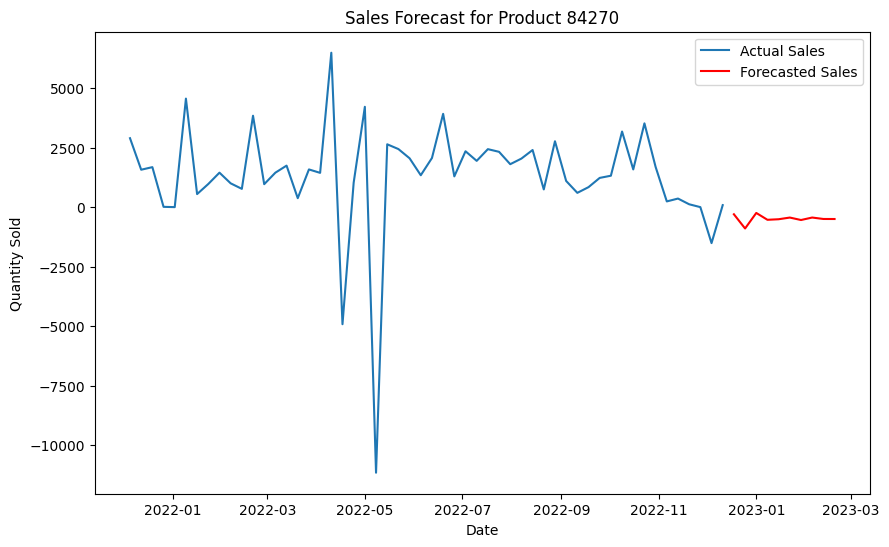

In [103]:
# Plot actual sales and forecast
plt.figure(figsize=(10, 6))
plt.plot(product_sales, label='Actual Sales')
plt.plot(forecast.index, forecast, label='Forecasted Sales', color='red')
plt.title(f'Sales Forecast for Product {stock}')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend()
plt.show()

In [104]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Evaluate the model (comparing predictions with actual sales)
predictions = model_fit.predict(start=0, end=len(product_sales)-1)
rmse = np.sqrt(mean_squared_error(product_sales, predictions))

print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 2348.8475336691663


In [105]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Assume product_sales is your time series data for a particular stock (weekly sales)
# Check if there are enough data points for seasonal estimation
if len(product_sales) >= 2 * 52:  # Check for at least 2 seasonal cycles
    # Fit the model with ETS if enough data
    model = ExponentialSmoothing(product_sales, trend='add', seasonal='add', seasonal_periods=52)
    model_fit = model.fit()

    # Forecast future sales for the next 10 periods (weeks)
    forecast = model_fit.forecast(steps=10)

    # Plot the forecast
    plt.figure(figsize=(10, 6))
    plt.plot(product_sales, label='Actual Sales')
    plt.plot(forecast.index, forecast, label='Forecasted Sales', color='red')
    plt.title(f'ETS Sales Forecast for Product {stock}')
    plt.xlabel('Date')
    plt.ylabel('Quantity Sold')
    plt.legend()
    plt.show()
else:
    print(f"Not enough data for product {stock} to estimate seasonality with a period of 52.")
    print(f"Consider using a shorter seasonal period or gathering more data.")

Not enough data for product 84270 to estimate seasonality with a period of 52.
Consider using a shorter seasonal period or gathering more data.


In [106]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Assume product_sales is the time series sales data (e.g., weekly sales)
# Reshape data to fit into LSTM [samples, time steps, features]
scaler = MinMaxScaler(feature_range=(0, 1))
product_sales_scaled = scaler.fit_transform(product_sales.values.reshape(-1, 1))

In [107]:
# Define the number of time steps and features
time_steps = 5
X = []
y = []

# Create the time step sequences for LSTM input
for i in range(time_steps, len(product_sales_scaled)):
    X.append(product_sales_scaled[i-time_steps:i, 0])
    y.append(product_sales_scaled[i, 0])

In [108]:
X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))


In [109]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
model.fit(X, y, epochs=10, batch_size=32)

# Predict future sales (assume you want to predict the next 10 weeks)
predicted_sales = model.predict(X[-10:])

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.5724
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4974 
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4208 
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3572 
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2845
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2257
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1613
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1072
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0577
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0283
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


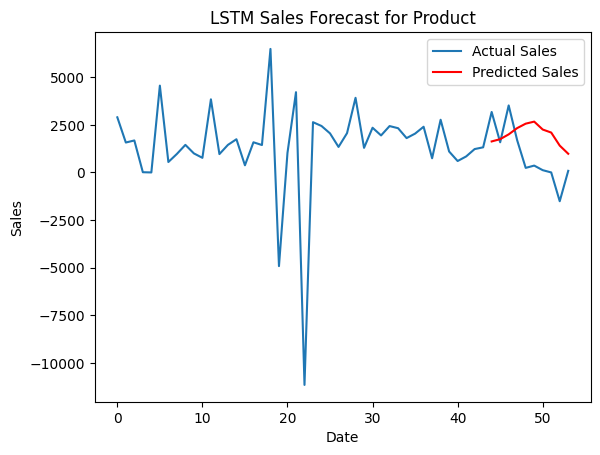

In [110]:
# Inverse transform to get the sales in original scale
predicted_sales = scaler.inverse_transform(predicted_sales)

# Plot the actual and predicted sales
plt.plot(product_sales.values, label='Actual Sales')
plt.plot(range(len(product_sales)-10, len(product_sales)), predicted_sales, color='red', label='Predicted Sales')
plt.title(f'LSTM Sales Forecast for Product')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [111]:
from prophet import Prophet

In [112]:
product_sales_prophet = product_sales.reset_index()  # Resetting index to access 'InvoiceDate'
product_sales_prophet.columns = ['ds', 'y']  # Prophet requires 'ds' for dates and 'y' for values

In [113]:
# Initialize the Prophet model
model = Prophet()

# Fit the model
model.fit(product_sales_prophet)

# Make future predictions for the next 15 weeks
future = model.make_future_dataframe(periods=15, freq='W')  # freq='W' for weekly data
forecast = model.predict(future)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpu9_gfzx0/9rkiou25.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpu9_gfzx0/9lthu1pl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89439', 'data', 'file=/tmp/tmpu9_gfzx0/9rkiou25.json', 'init=/tmp/tmpu9_gfzx0/9lthu1pl.json', 'output', 'file=/tmp/tmpu9_gfzx0/prophet_modelzcw5ec_8/prophet_model-20241006191016.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:10:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:10:17 - cmdstanpy - INFO - Chai

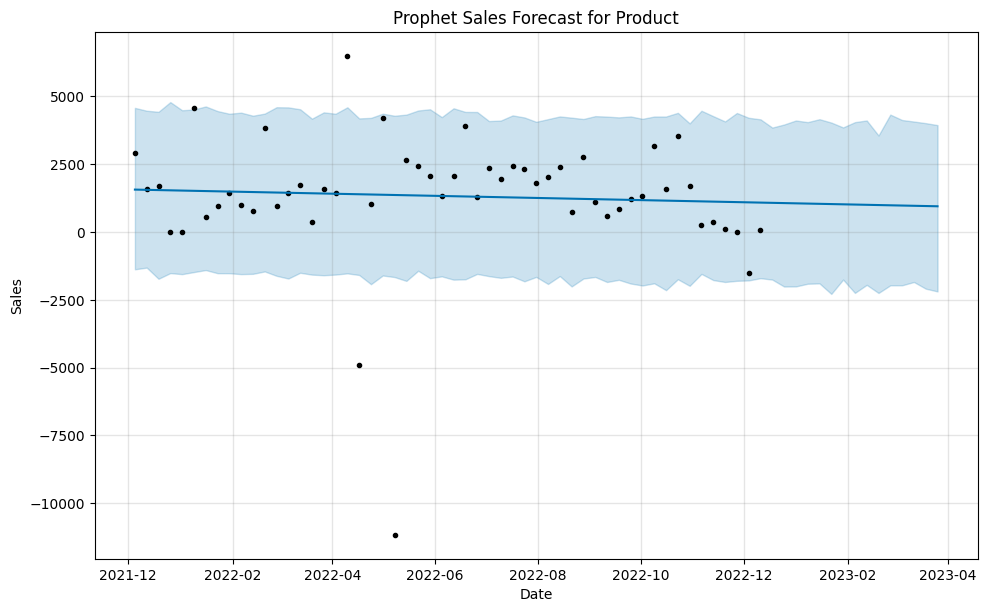

In [114]:
# Plot the forecast
fig = model.plot(forecast)
plt.title(f'Prophet Sales Forecast for Product')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [115]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Generate synthetic data for demonstration
np.random.seed(42)
dates = pd.date_range(start='2020-01-01', periods=100)
data = np.random.randint(10, 100, size=len(dates)) + np.arange(len(dates))  # Trend + noise
df = pd.DataFrame(data, index=dates, columns=['sales'])

# Split data into train and test
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# ARIMA Model
def arima_forecast(train, test):
    model = ARIMA(train, order=(5, 1, 0))  # Adjust order as necessary
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test))
    return forecast

# Exponential Smoothing (ETS)
def ets_forecast(train, test):
    model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=12)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test))
    return forecast

# LSTM Model
def lstm_forecast(train, test):
    # Reshape data for LSTM
    X_train = train.values.reshape(-1, 1, 1)
    y_train = train.values
    X_test = test.values.reshape(-1, 1, 1)

    model = keras.Sequential([
        layers.LSTM(50, activation='relu', input_shape=(1, 1)),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=200, verbose=0)

    forecast = model.predict(X_test)
    return forecast.flatten()

# Prophet Model
def prophet_forecast(train, test):
    train_reset = train.reset_index().rename(columns={'index': 'ds', 'sales': 'y'})
    model = Prophet()
    model.fit(train_reset)

    future = model.make_future_dataframe(periods=len(test))
    forecast = model.predict(future)
    return forecast['yhat'][-len(test):].values

# Forecast with all models
arima_pred = arima_forecast(train, test)
ets_pred = ets_forecast(train, test)
lstm_pred = lstm_forecast(train, test)
prophet_pred = prophet_forecast(train, test)

# Calculate accuracy metrics
def calculate_accuracy(test, predictions):
    rmse = np.sqrt(mean_squared_error(test, predictions))
    mae = mean_absolute_error(test, predictions)
    return rmse, mae

# Evaluate models
arima_rmse, arima_mae = calculate_accuracy(test, arima_pred)
ets_rmse, ets_mae = calculate_accuracy(test, ets_pred)
lstm_rmse, lstm_mae = calculate_accuracy(test, lstm_pred)
prophet_rmse, prophet_mae = calculate_accuracy(test, prophet_pred)

# Print results
print("Model Performance:")
print(f"ARIMA RMSE: {arima_rmse}, MAE: {arima_mae}")
print(f"ETS RMSE: {ets_rmse}, MAE: {ets_mae}")
print(f"LSTM RMSE: {lstm_rmse}, MAE: {lstm_mae}")
print(f"Prophet RMSE: {prophet_rmse}, MAE: {prophet_mae}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpu9_gfzx0/y2_vjhuh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpu9_gfzx0/8rsx365q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51610', 'data', 'file=/tmp/tmpu9_gfzx0/y2_vjhuh.json', 'init=/tmp/tmpu9_gfzx0/8rsx365q.json', 'output', 'file=/tmp/tmpu9_gfzx0/prophet_model_v12pq1h/prophet_model-20241006191029.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:10:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:10:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model Performance:
ARIMA RMSE: 32.20497976508059, MAE: 26.76869528267572
ETS RMSE: 36.682076050182594, MAE: 30.860449282906057
LSTM RMSE: 0.4911994287214324, MAE: 0.4176643371582031
Prophet RMSE: 30.668918037030586, MAE: 25.292063452027314


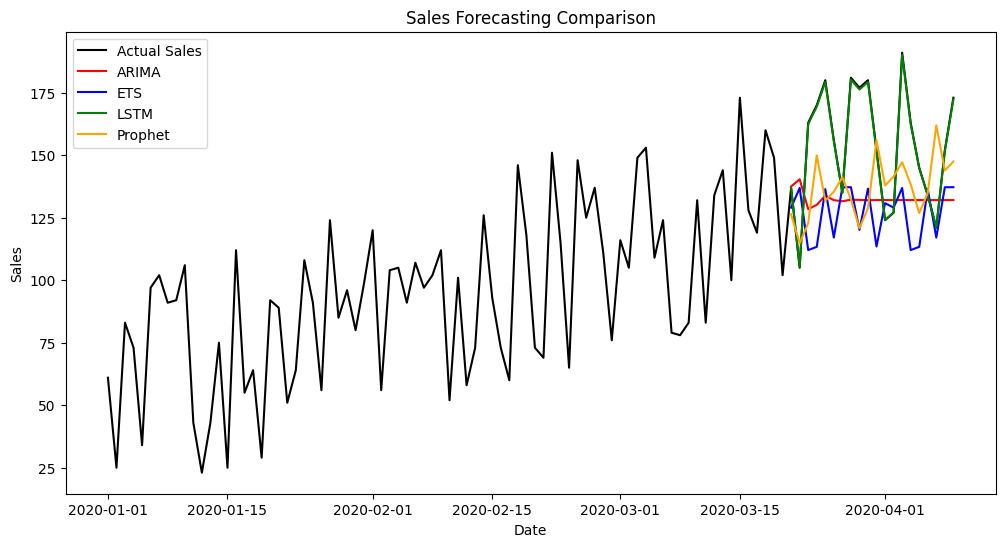

In [116]:
# Plot the predictions
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['sales'], label='Actual Sales', color='black')
plt.plot(test.index, arima_pred, label='ARIMA', color='red')
plt.plot(test.index, ets_pred, label='ETS', color='blue')
plt.plot(test.index, lstm_pred, label='LSTM', color='green')
plt.plot(test.index, prophet_pred, label='Prophet', color='orange')
plt.legend()
plt.title('Sales Forecasting Comparison')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [117]:
# Explore the data
print(merged_data.info())
print(merged_data.describe())

# Convert InvoiceDate to datetime
merged_data['InvoiceDate'] = pd.to_datetime(merged_data['InvoiceDate'])

# Extract features from InvoiceDate
merged_data['Year'] = merged_data['InvoiceDate'].dt.year
merged_data['Month'] = merged_data['InvoiceDate'].dt.month
merged_data['Day'] = merged_data['InvoiceDate'].dt.day

# Check for missing values
print(merged_data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1089065 entries, 0 to 1089064
Data columns (total 9 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1089065 non-null  object        
 1   StockCode    1089065 non-null  object        
 2   Quantity     1089065 non-null  int64         
 3   Price        1089065 non-null  float64       
 4   Customer ID  876656 non-null   float64       
 5   InvoiceDate  1089065 non-null  datetime64[ns]
 6   Description  860401 non-null   object        
 7   Country      35598 non-null    object        
 8   Revenue      1089065 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 74.8+ MB
None
           Quantity         Price    Customer ID  \
count  1.089065e+06  1.089065e+06  876656.000000   
mean   1.028090e+01  4.569080e+00   15355.741506   
min   -9.600000e+03 -5.359436e+04   12346.000000   
25%    1.000000e+00  1.250000e+0

In [118]:
# Drop rows with any null values
merged_data_cleaned = merged_data.dropna()

# Drop rows with null values in specific columns (e.g., 'Customer ID', 'Country', 'Description')
merged_data_cleaned = merged_data.dropna(subset=['Customer ID', 'Country', 'Description'])


# Fill null values with 0 in numeric columns
merged_data['Customer ID'].fillna(0, inplace=True)
merged_data['Revenue'].fillna(0, inplace=True)

# Fill null values with 'Unknown' in string columns
merged_data['Country'].fillna('Unknown', inplace=True)
merged_data['Description'].fillna('Unknown', inplace=True)

In [119]:
# Impute 'Customer ID' with the median value
merged_data['Customer ID'].fillna(merged_data['Customer ID'].median(), inplace=True)

# Impute 'Revenue' with the mean value
merged_data['Revenue'].fillna(merged_data['Revenue'].mean(), inplace=True)

In [120]:
# Drop columns with more than a certain percentage of null values (e.g., 95%)
threshold = 0.95
merged_data = merged_data.dropna(thresh=int((1 - threshold) * len(merged_data)), axis=1)

In [121]:
# Aggregate features by Customer ID
customer_data = merged_data.groupby('Customer ID').agg({
    'Invoice': 'nunique',  # Number of unique invoices per customer
    'Revenue': 'sum',      # Total revenue per customer
    'Quantity': 'sum'      # Total quantity purchased
}).reset_index()

In [122]:
# Rename columns for clarity
customer_data.rename(columns={'Invoice': 'NumPurchases', 'Revenue': 'TotalRevenue', 'Quantity': 'TotalQuantity'}, inplace=True)

# Merge aggregated customer data back to the original DataFrame
merged_data = merged_data.merge(customer_data, on='Customer ID', how='left')

In [123]:
features = merged_data[['Quantity', 'Price', 'Year', 'Month', 'Day', 'NumPurchases', 'TotalRevenue']]
target = merged_data['Revenue']

In [124]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [125]:
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

# Train Decision Tree
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)

# Train XGBoost
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [126]:
dt_predictions = dt_model.predict(X_test)
xgb_predictions = xgb_model.predict(X_test)

In [127]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Evaluate Decision Tree Model
dt_mae = mean_absolute_error(y_test, dt_predictions)
dt_mse = mean_squared_error(y_test, dt_predictions)
dt_r2 = r2_score(y_test, dt_predictions)

print("Decision Tree Model Performance:")
print(f"MAE: {dt_mae}, MSE: {dt_mse}, R²: {dt_r2}")

# Evaluate XGBoost Model
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)

print("\nXGBoost Model Performance:")
print(f"MAE: {xgb_mae}, MSE: {xgb_mse}, R²: {xgb_r2}")

Decision Tree Model Performance:
MAE: 0.2871974124597465, MSE: 5696.4033764408, R²: 0.6774300195116517

XGBoost Model Performance:
MAE: 2.7948305366115185, MSE: 4716.648824656681, R²: 0.7329105369131141


In [128]:
# Assuming merged_data is sorted by InvoiceDate
train_size = int(len(merged_data) * 0.8)
train_data = merged_data[:train_size]
test_data = merged_data[train_size:]

In [129]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [130]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Sample data loading (replace with your actual data)
# merged_data = pd.read_csv('path_to_your_data.csv')

# Create a datetime column from Year, Month, and Day
merged_data['InvoiceDate'] = pd.to_datetime(merged_data[['Year', 'Month', 'Day']])

# Check if the new InvoiceDate was created correctly
print(merged_data['InvoiceDate'].head())

0   2021-12-01
1   2021-12-01
2   2021-12-01
3   2021-12-01
4   2021-12-01
Name: InvoiceDate, dtype: datetime64[ns]


In [131]:
# Create a new column for week (using the start of the week)
merged_data['Week'] = merged_data['InvoiceDate'].dt.to_period('W').dt.start_time

In [132]:
# Aggregate the data to get weekly sales for each product
weekly_sales = merged_data.groupby(['StockCode', 'Week']).agg({'Quantity': 'sum',
                                                                'TotalRevenue': 'sum'}).reset_index()

In [133]:
# Filter data for a specific product (replace 'YOUR_PRODUCT_ID' with the actual StockCode)
product_data = weekly_sales[weekly_sales['StockCode'] == '10002']  # Example: 'A123'

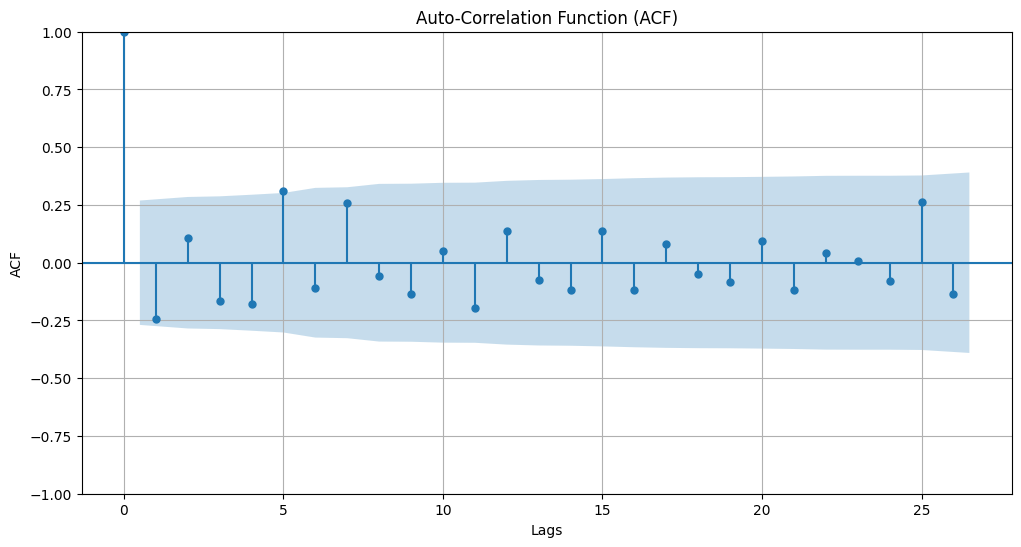

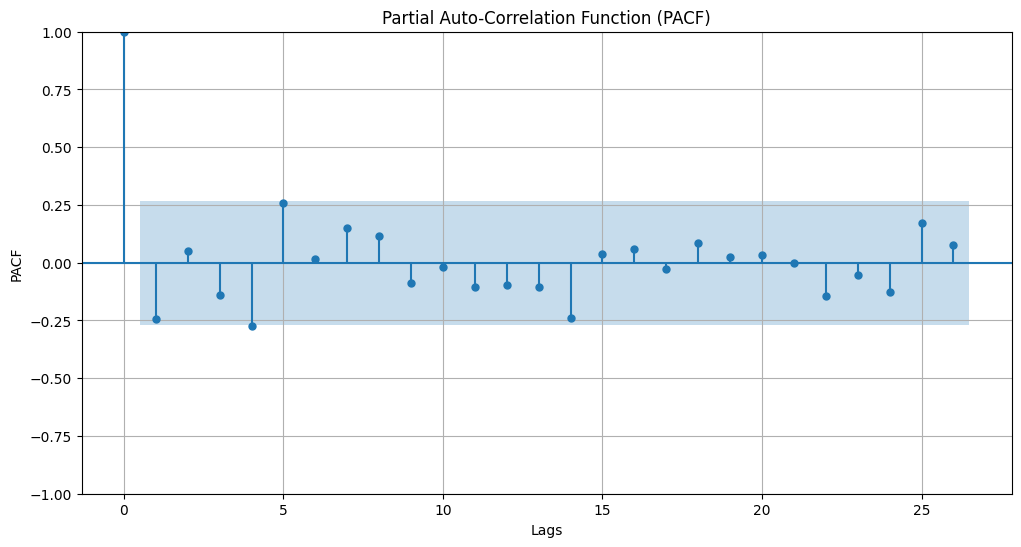

In [134]:
# Set 'Week' as the index
product_data.set_index('Week', inplace=True)

# Calculate the maximum allowed lags (50% of the sample size)
max_lags = len(product_data) // 2

# ACF Plot
plt.figure(figsize=(12, 6))
plot_acf(product_data['Quantity'], lags=min(30, max_lags), ax=plt.gca())  # Use min to ensure lags doesn't exceed max_lags
plt.title('Auto-Correlation Function (ACF)')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.grid()
plt.show()

# PACF Plot
plt.figure(figsize=(12, 6))
plot_pacf(product_data['Quantity'], lags=min(30, max_lags), ax=plt.gca())  # Use min to ensure lags doesn't exceed max_lags
plt.title('Partial Auto-Correlation Function (PACF)')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.grid()
plt.show()

In [135]:
top_10_revenue = merged_data.groupby('StockCode')['TotalRevenue'].sum().nlargest(10).reset_index()
print(top_10_revenue)

  StockCode  TotalRevenue
0     22423  8.301920e+09
1    85123A  4.151893e+09
2     20713  4.105946e+09
3       DOT  4.087147e+09
4    85099B  3.231098e+09
5     21181  2.995344e+09
6     22197  2.835804e+09
7     47566  2.663240e+09
8     22502  2.487156e+09
9     22355  2.304622e+09


In [136]:
top_10_revenue.to_csv('top_10_revenue.csv', index=False)

# Optional: Print a confirmation message
print("top_10_revenue saved to 'top_10_revenue.csv'")

top_10_revenue saved to 'top_10_revenue.csv'


In [137]:
df=pd.read_csv('top_10_revenue.csv')
df.head()

,StockCode,TotalRevenue
0,22423,8.301920e+09
1,85123A,4.151893e+09
2,20713,4.105946e+09
3,DOT,4.087147e+09
4,85099B,3.231098e+09


In [138]:
# Calculate total revenue per product
top_products = df.groupby('StockCode')['TotalRevenue'].sum().reset_index()

# Sort the products by total revenue and get the top 10
top_products = top_products.sort_values(by='TotalRevenue', ascending=False).head(10)

# Convert to a list of dictionaries for easier use in the app
top_products_list = top_products.to_dict(orient='records')

In [143]:
import joblib

# Save the trained model to a file
joblib.dump(xgb_model, 'trained_model.pkl')

['trained_model.pkl']

In [145]:
from google.colab import files
uploaded = files.upload()


Saving app.py to app.py


In [160]:
from app import app

In [163]:
!python3 /content/app.py

 * Serving Flask app 'app'
 * Debug mode: on
 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with watchdog (inotify)
 * Debugger is active!
 * Debugger PIN: 384-711-256
